<a href="https://colab.research.google.com/github/abubakry121/DCCRN/blob/master/29StarGanbest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
import os
import librosa
import soundfile as sf
from IPython.display import Audio

# Select a few real audio files to play
num_real_samples_to_play = 3
real_audio_files_to_play = []
emotions_to_play = []

# Iterate through the dataset directory to find a few audio files
count = 0
for actor in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_id = file.split("-")[2]
                if emotion_id in emotions:
                    real_audio_files_to_play.append(os.path.join(actor_path, file))
                    emotions_to_play.append(emotions[emotion_id])
                    count += 1
                    if count >= num_real_samples_to_play:
                        break
        if count >= num_real_samples_to_play:
            break

# Play the selected real audio files
print("Real Audio Samples:")
for i, audio_path in enumerate(real_audio_files_to_play):
    print(f"Real Audio ({emotions_to_play[i]}):")
    display(Audio(audio_path))

Real Audio Samples:
Real Audio (fearful):


Real Audio (fearful):


Real Audio (fearful):


In [13]:
# Convert conditioned fake MFCCs to audio waveforms
conditioned_fake_waveforms = []
for mfcc_sample in fake_samples_conditioned.numpy():
    waveform = mfcc_to_waveform(mfcc_sample[:,:,0]) # Use the previously defined mfcc_to_waveform
    conditioned_fake_waveforms.append(waveform)

# Save conditioned fake waveforms to temporary files
conditioned_audio_paths = []
for i, waveform in enumerate(conditioned_fake_waveforms):
    # Determine the original real sample index and target emotion for naming
    real_sample_index = i // len(target_emotion_indices)
    target_emotion_index = i % len(target_emotion_indices)
    target_emotion_name = target_emotion_labels[target_emotion_index]

    audio_path = f"/tmp/fake_conditioned_audio_sample_{real_sample_index}_target_{target_emotion_name}.wav"
    sf.write(audio_path, waveform, 16000)
    conditioned_audio_paths.append((audio_path, real_sample_index, target_emotion_name)) # Store path, real sample index, and target emotion

print("Conditioned fake audio files saved.")

Conditioned fake audio files saved.


Here are the conditioned fake audio samples:

In [ ]:
from IPython.display import Audio

# Assuming real_audio_files_to_play and conditioned_audio_paths are available from previous cells
# Need to ensure real_audio_files_to_play contains the audio files corresponding to the real samples used for generation

# Since we used real_samples_subset (first num_samples_to_generate from the dataset),
# we need to find the original paths for these samples.
# This requires a mapping from the dataset index to the original file path.
# For simplicity in this modification, I will assume that the first num_samples_to_generate
# files found when iterating through the data_dir are the ones used.
# A more robust solution would involve storing the original file paths during dataset loading.

# Let's re-collect the paths for the first num_samples_to_generate real samples
real_audio_paths_for_comparison = []
count = 0
for actor in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_id = file.split("-")[2]
                if emotion_id in emotions:
                    real_audio_paths_for_comparison.append(os.path.join(actor_path, file))
                    count += 1
                    if count >= num_samples_to_generate:
                        break
        if count >= num_samples_to_generate:
            break

print("Comparing Real and Fake Audio Samples:")
for i, (audio_path, real_sample_index, target_emotion_name) in enumerate(conditioned_audio_paths):
    # Play the corresponding real audio sample
    if real_sample_index < len(real_audio_paths_for_comparison):
        print(f"\nReal Audio (Original Sample {real_sample_index}):")
        display(Audio(real_audio_paths_for_comparison[real_sample_index]))

    # Play the generated fake audio sample
    print(f"Fake Audio (Based on Real Sample {real_sample_index}, Target: {target_emotion_name}):")
    display(Audio(audio_path))

In [2]:
!pip install librosa soundfile tensorflow --quiet

import os
import librosa
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [3]:
# Path to RAVDESS (make sure it's correct)
data_dir ="/content/drive/MyDrive/STARGAN/RAVDESS "

def extract_mfcc(file_path, sr=16000, n_mfcc=40, max_len=128):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_combined = np.vstack([mfcc, mfcc_delta, mfcc_delta2])  # (120, time)
    mfcc_combined = librosa.util.normalize(mfcc_combined)

    # Pad/crop time dimension → 128
    if mfcc_combined.shape[1] < max_len:
        pad_width = max_len - mfcc_combined.shape[1]
        mfcc_combined = np.pad(mfcc_combined, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc_combined = mfcc_combined[:, :max_len]

    # Pad feature dimension (120 → 128)
    if mfcc_combined.shape[0] < 128:
        pad_height = 128 - mfcc_combined.shape[0]
        mfcc_combined = np.pad(mfcc_combined, ((0,pad_height),(0,0)), mode='constant')

    return mfcc_combined  # shape (128,128)


In [4]:
X, y = [], []
# Define the list of emotions to include based on their IDs in the file names
# Example: Assuming you want emotions with IDs 1, 2, 3, and 4
# Emotions in RAVDESS
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
num_classes = len(emotions)

for actor in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_id = file.split("-")[2]
                if emotion_id in emotions:
                    mfcc_feat = extract_mfcc(os.path.join(actor_path, file))
                    X.append(mfcc_feat)
                    y.append(int(emotion_id)-1) # Adjust index if needed, depending on how emotions are mapped

X = np.array(X)[..., np.newaxis]  # (samples, 128,128,1)
y = np.array(y)
# Assuming you have a variable 'num_classes' defined somewhere for the number of emotion categories
# If not, you might need to determine it from the unique values in 'y'
# num_classes = len(np.unique(y))
# For now, assuming num_classes is defined elsewhere
y_onehot = to_categorical(y, num_classes=len(emotions)) # Use len(emotions) or the actual number of classes

print("Dataset ready:", X.shape, y_onehot.shape)

Dataset ready: (1300, 128, 128, 1) (1300, 8)


In [5]:
import tensorflow as tf
import numpy as np
import os
import librosa
from tensorflow.keras.utils import to_categorical
# ----------------- GAN -----------------
from tensorflow.keras.layers import (Input, Conv2D, Conv2DTranspose,
                                     LeakyReLU, BatchNormalization, Concatenate, Reshape, Embedding, multiply, Dense)
from tensorflow.keras.models import Model

# Path to RAVDESS (make sure it's correct)
data_dir ="/content/drive/MyDrive/STARGAN/RAVDESS "

def extract_mfcc(file_path, sr=16000, n_mfcc=40, max_len=128):
    y, sr = librosa.load(file_path, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc, order=2)
    mfcc_combined = np.vstack([mfcc, mfcc_delta, mfcc_delta2])  # (120, time)
    mfcc_combined = librosa.util.normalize(mfcc_combined)

    # Pad/crop time dimension → 128
    if mfcc_combined.shape[1] < max_len:
        pad_width = max_len - mfcc_combined.shape[1]
        mfcc_combined = np.pad(mfcc_combined, ((0,0),(0,pad_width)), mode='constant')
    else:
        mfcc_combined = mfcc_combined[:, :max_len]

    # Pad feature dimension (120 → 128)
    if mfcc_combined.shape[0] < 128:
        pad_height = 128 - mfcc_combined.shape[0]
        mfcc_combined = np.pad(mfcc_combined, ((0,pad_height),(0,0)), mode='constant')

    return mfcc_combined  # shape (128,128)

X, y = [], []
# Define the list of emotions to include based on their IDs in the file names
# Example: Assuming you want emotions with IDs 1, 2, 3, and 4
# Emotions in RAVDESS
emotions = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised"
}
num_classes = len(emotions)

for actor in os.listdir(data_dir):
    actor_path = os.path.join(data_dir, actor)
    if os.path.isdir(actor_path):
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                emotion_id = file.split("-")[2]
                if emotion_id in emotions:
                    mfcc_feat = extract_mfcc(os.path.join(actor_path, file))
                    X.append(mfcc_feat)
                    y.append(int(emotion_id)-1) # Adjust index if needed, depending on how emotions are mapped

X = np.array(X)[..., np.newaxis]  # (samples, 128,128,1)
y = np.array(y)
# Assuming you have a variable 'num_classes' defined somewhere for the number of emotion categories
# If not, you might need to determine it from the unique values in 'y'
# num_classes = len(np.unique(y))
# For now, assuming num_classes is defined elsewhere
y_onehot = to_categorical(y, num_classes=len(emotions)) # Use len(emotions) or the actual number of classes

print("Dataset ready:", X.shape, y_onehot.shape)


def build_generator(input_shape=(128,128,1), num_classes=8):
    inputs = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))

    # Embed the label and reshape it to match the spatial dimensions of the input
    label_embedding = Dense(input_shape[0] * input_shape[1])(label_input)
    label_embedding = Reshape((input_shape[0], input_shape[1], 1))(label_embedding)

    # Concatenate the input image with the label embedding
    concatenated_inputs = Concatenate()([inputs, label_embedding])

    # Encoder
    e1 = Conv2D(64, 4, strides=2, padding="same")(concatenated_inputs)    # 60x64x64
    e1 = LeakyReLU(0.2)(e1)

    e2 = Conv2D(128, 4, strides=2, padding="same")(e1)       # 30x32x128
    e2 = BatchNormalization()(e2)
    e2 = LeakyReLU(0.2)(e2)

    e3 = Conv2D(256, 4, strides=2, padding="same")(e2)       # 15x16x256
    e3 = BatchNormalization()(e3)
    e3 = LeakyReLU(0.2)(e3)

    # Bottleneck
    b = Conv2D(512, 4, strides=2, padding="same")(e3)        # 8x8x512
    b = BatchNormalization()(b)
    b = LeakyReLU(0.2)(b)

    # Decoder
    d1 = Conv2DTranspose(256, 4, strides=2, padding="same", activation="relu")(b)
    d1 = Concatenate()([d1, e3])

    d2 = Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(d1)
    d2 = Concatenate()([d2, e2])

    d3 = Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(d2)
    d3 = Concatenate()([d3, e1])

    outputs = Conv2DTranspose(1, 4, strides=2, padding="same", activation="tanh")(d3)

    return Model([inputs, label_input], outputs, name="Generator")

def build_discriminator(input_shape=(128,128,1), num_classes=8):
    inputs = Input(shape=input_shape)
    label_input = Input(shape=(num_classes,))

    # Embed the label and reshape it to match the spatial dimensions of the input
    label_embedding = Dense(input_shape[0] * input_shape[1])(label_input)
    label_embedding = Reshape((input_shape[0], input_shape[1], 1))(label_embedding)

    # Concatenate the input image with the label embedding
    concatenated_inputs = Concatenate()([inputs, label_embedding])

    x = Conv2D(64, 4, strides=2, padding="same")(concatenated_inputs)   # 60x64x64
    x = LeakyReLU(0.2)(x)

    x = Conv2D(128, 4, strides=2, padding="same")(x)    # 30x32x128
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(256, 4, strides=2, padding="same")(x)    # 15x16x256
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2D(512, 4, strides=2, padding="same")(x)    # 8x8x512
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    out = Conv2D(1, 4, padding="same")(x)               # PatchGAN output

    return Model([inputs, label_input], out, name="Discriminator")

# Losses
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_pred, real, fake, lambda_recon=10):
    adv_loss = bce(tf.ones_like(fake_pred), fake_pred)
    recon_loss = tf.reduce_mean(tf.abs(real - fake))
    return adv_loss + lambda_recon * recon_loss

def discriminator_loss(real_pred, fake_pred):
    real_loss = bce(tf.ones_like(real_pred), real_pred)
    fake_loss = bce(tf.zeros_like(fake_pred), fake_pred)
    return (real_loss + fake_loss) * 0.5

# Models
generator = build_generator(num_classes=num_classes)
discriminator = build_discriminator(num_classes=num_classes)

g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_mfcc, real_labels):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake data with random labels for the generator
        noise_labels = tf.random.uniform(shape=(tf.shape(real_mfcc)[0],), minval=0, maxval=num_classes, dtype=tf.int32)
        fake_labels = tf.one_hot(noise_labels, depth=num_classes)
        fake_mfcc = generator([real_mfcc, fake_labels], training=True)

        # Discriminator predictions
        real_pred = discriminator([real_mfcc, real_labels], training=True)
        fake_pred = discriminator([fake_mfcc, fake_labels], training=True)

        # Calculate losses
        g_loss = generator_loss(fake_pred, real_mfcc, fake_mfcc)
        d_loss = discriminator_loss(real_pred, fake_pred)

    # Compute and apply gradients
    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return g_loss, d_loss

# Dataset
BUFFER_SIZE = 1000
BATCH_SIZE = 64
dataset = tf.data.Dataset.from_tensor_slices((X, y_onehot)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Dataset ready: (1300, 128, 128, 1) (1300, 8)


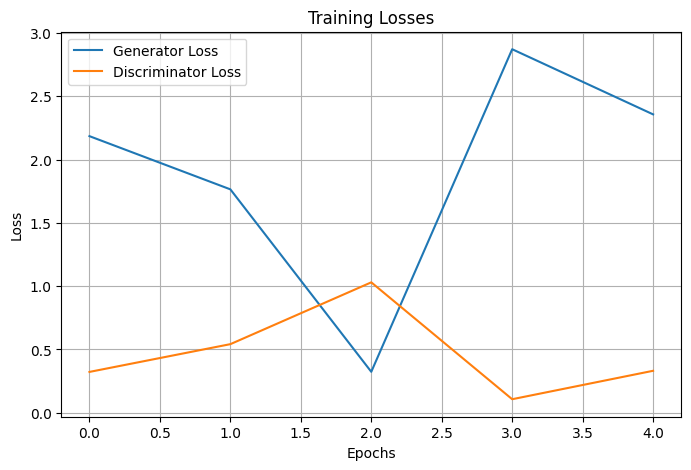


Epoch 6/50


In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

EPOCHS = 50
g_losses, d_losses = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    for real_batch, label_batch in dataset:
        g_loss, d_loss = train_step(real_batch, label_batch)

    g_losses.append(g_loss.numpy())
    d_losses.append(d_loss.numpy())

    # Print progress every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | G Loss: {g_loss:.4f} | D Loss: {d_loss:.4f}")

    # Update plot every 100 epochs
    #if (epoch + 1) % 100 == 0:
    clear_output(wait=True)
    plt.figure(figsize=(8,5))
    plt.plot(g_losses, label="Generator Loss")
    plt.plot(d_losses, label="Discriminator Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Losses")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# Generate more fake samples with specific target emotions
num_samples_to_generate = 3 # Hyperparameter: Number of fake samples to generate
real_samples, real_emotions_onehot = next(iter(dataset))

# Select a few real samples
real_samples_subset = real_samples[:num_samples_to_generate].numpy()
real_emotions_subset = np.argmax(real_emotions_onehot[:num_samples_to_generate].numpy(), axis=1) # Get original emotion index

# Define target emotions (e.g., neutral, happy, angry)
# Make sure these indices correspond to your emotion mapping
target_emotion_indices = [0, 2, 4] # Example: 0 for neutral, 2 for happy, 4 for angry
target_emotion_labels = [emotions[f"0{i+1}"] for i in target_emotion_indices] # Get emotion names

# Create target emotion one-hot labels for the generator
target_emotion_onehot = tf.one_hot(target_emotion_indices, depth=num_classes)

# Repeat the real samples for each target emotion
real_samples_repeated = tf.repeat(real_samples_subset, len(target_emotion_indices), axis=0)
target_emotion_onehot_repeated = tf.tile(target_emotion_onehot, [num_samples_to_generate, 1])

# Generate fake samples conditioned on target emotions
fake_samples_conditioned = generator([real_samples_repeated, target_emotion_onehot_repeated], training=False)

# Plot example MFCCs for real and conditioned fake samples
for i in range(num_samples_to_generate):
    plt.figure(figsize=(15, 8))

    # Plot Real MFCC
    plt.subplot(1, len(target_emotion_indices) + 1, 1)
    librosa.display.specshow(real_samples_subset[i, :, :, 0], x_axis='time')
    plt.title(f"Real MFCC ({emotions[f'0{real_emotions_subset[i]+1}']})") # Display original emotion
    plt.colorbar()

    # Plot Conditioned Fake MFCCs
    for j in range(len(target_emotion_indices)):
        plt.subplot(1, len(target_emotion_indices) + 1, j + 2)
        fake_mfcc_sample = fake_samples_conditioned[i * len(target_emotion_indices) + j, :, :, 0].numpy()
        librosa.display.specshow(fake_mfcc_sample, x_axis='time')
        plt.title(f"Fake MFCC (Target: {target_emotion_labels[j]})")
        plt.colorbar()

    plt.tight_layout()
    plt.show()

Now you can play the generated audio files.